<a href="https://colab.research.google.com/github/ibonetc/AI_Deep-Learning/blob/main/DA_SeriesDeTiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM para series de tiempo

Los problemas de predicción con series de tiempo, según las variables pueden ser:

- Univariados: Una variable medida en el tiempo
- Multivariados: Varias variables medidas en el tiempo

Según la predicción:

- Un paso(One step): Si el problema requiere predicción del próximo paso de tiempo
- Multi-paso(Multi-step): Si se requiere predecir más de un paso en el tiempo.

Para mayor profundidad se puede ver el libro: Jason Brownlee, Deep Learning for Time Series Forecasting, 2019



## LSTM
Las redes recurrentes como Long Short-Term Memory (LSTM), a diferencia de un MLP o una red convolucional agregan el manejo explícito del orden entre observaciones al aprender una función de mapeo de entradas a salidas. En lugar de mapear entradas a salidas solo, la red es capaz de aprender una función de mapeo para las entradas a lo largo del tiempo hasta una salida.

### Preparación de los datos

Para redes LSTM los datos se series de tiempo deben tener una preparación previa.

En las redes LSTM se debe especificar la entrada de los datos, los cuales tienen tres dimensiones, que son:
- Ejemplos o casos: Cantidad de casos de la base
- Pasos de tiempo: Cantidad de puntos de observación en los ejemplos.
- Rasgos: Observaciones en el tiempo, o sea, acá los rasgos es la cantidad de variables en el tiempo que se tienen, en el caso de series de tiempo univariadas este valor es 1.

La serie se debe transformar de forma que se analice por ventanas

In [1]:
import numpy as np

In [ ]:
# dividir una serie univariada en varios ejemplo a partir de un número de pasos
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# Ejemplo de una serie univariada, un caso
series = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
print(series.shape)

(10,)


In [ ]:
# transformar a un problema supervisado
X, y = split_sequence(series, 3)
print(X.shape, y.shape)
print('División de la serie:')
print([['   X  '],['y']])
[[x.tolist(),[yi]] for x,yi in zip(X,y)]

(7, 3) (7,)
División de la serie:
[['   X  '], ['y']]


[[[1, 2, 3], [4]],
 [[2, 3, 4], [5]],
 [[3, 4, 5], [6]],
 [[4, 5, 6], [7]],
 [[5, 6, 7], [8]],
 [[6, 7, 8], [9]],
 [[7, 8, 9], [10]]]

In [ ]:
# transformar las entradas de [samples, features] a [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)

(7, 3, 1)


Para el caso de LSTM se necesita procesar los ejemplos donde cada ejemplo es una simple secuencia, pero si la secuencia es muy grande (mayor que 400 pasos de tiempo) es mejor dividirla. Esta división puede hacerse con superposición o no.

Por ejemplo, en este caso tenemos una serie de 5000 pasos o puntos, y la dividimos en 25 subseries.

In [ ]:
# Crear una serie de tiempo de 5000 puntos
data = list()
n = 5000
data=[[i+1, (i+1)*10] for i in range(n)]
data = np.array(data)
# eliminar la columna de tiempo
data = data[:, 1]
# dividir la serie en 25 subseries de tamaño 200 (5000/200 = 25)
samples = list()
length = 200
for i in range(0,n,length):
  sample = data[i:i+length]
  samples.append(sample)
print(len(samples))

25


In [ ]:
print(data)
print(samples)

[   10    20    30 ... 49980 49990 50000]
[array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
        120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
        230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
        340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
        450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
        560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
        670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
        780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
        890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
       1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
       1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
       1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
       1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
       1

Para cambiar las dimensicones (reshape) de los datos:

In [ ]:
len(samples)

25

In [ ]:
# convertir lista de arreglos a un arreglo 2D
data = np.array(samples)
print(data.shape)

(25, 200)


In [ ]:
# reshape a [samples, timesteps, features]
data = data.reshape((data.shape[0], data.shape[1], 1))
print(data.shape)

(25, 200, 1)


### Ejemplo usando LSTM con series univariadas

In [ ]:
# Preparación de los datos
# Suponiendo la siguiente serie
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# Seleccionando como paso de tiempo 3
n_steps = 3
# Dividiendo la serie
X, y = split_sequence(raw_seq, n_steps)
# Mostrando los datos
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [ ]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)

(6, 3, 1)


#### Vanilla LSTM

Este es un modelo con una simple capa LSTM, y una capa de salida para la predicción.

A diferencia de una red CNN que lee a traves del vectro de entrada completo, LSTM lee un paso de tiempo cada vez y contruye una representanción interna que puede ser usada como un contexto aprendido para hacer una prediccion.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Bidirectional

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

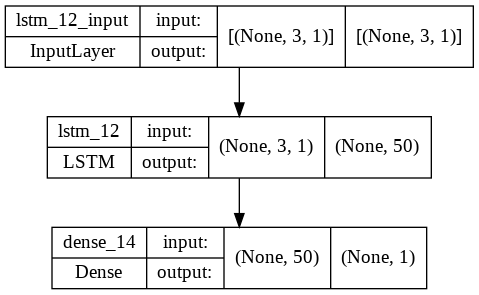

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 1s 967ms/step - loss: 2875.5266
Epoch 2/500
1/1 [==============================] - 0s 14ms/step - loss: 2809.7478
Epoch 3/500
1/1 [==============================] - 0s 17ms/step - loss: 2744.4622
Epoch 4/500
1/1 [==============================] - 0s 17ms/step - loss: 2679.4749
Epoch 5/500
1/1 [==============================] - 0s 13ms/step - loss: 2614.5920
Epoch 6/500
1/1 [==============================] - 0s 13ms/step - loss: 2549.5840
Epoch 7/500
1/1 [==============================] - 0s 13ms/step - loss: 2484.1877
Epoch 8/500
1/1 [==============================] - 0s 17ms/step - loss: 2418.1096
Epoch 9/500
1/1 [==============================] - 0s 14ms/step - loss: 2351.0444
Epoch 10/500
1/1 [==============================] - 0s 11ms/step - loss: 2282.6931
Epoch 11/500
1/1 [==============================] - 0s 14ms/step - loss: 2212.7888
Epoch 12/500
1/1 [==============================] - 0s 13ms/step - loss: 2141.1113
Epoch 13/500

Probando la predicción del modelo

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.37087]]


#### Stacked LSTM

Es un modelo con múltiples capas LSTM.

Una capa LSTM requiere una entrada tridimensional y los LSTM de forma predeterminada producirán una salida bidimensional como una interpretación desde el final de la secuencia.
Para poder poner varias capas LSTM, podemos hacer que la capa LSTM genere un valor para cada paso de tiempo en los datos de entrada estableciendo las secuencias de retorno verdadero (*return_sequences=True*). Esto nos permite tener una salida 3D de la capa LSTM oculta como entrada a la siguiente. Por lo tanto, podemos definir un Satcked LSTM de la siguiente manera:

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

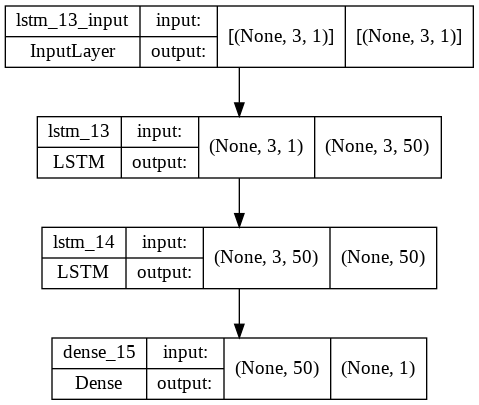

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=300)

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 4476.9375
Epoch 2/300
1/1 [==============================] - 0s 21ms/step - loss: 4438.5005
Epoch 3/300
1/1 [==============================] - 0s 24ms/step - loss: 4400.5044
Epoch 4/300
1/1 [==============================] - 0s 17ms/step - loss: 4361.3794
Epoch 5/300
1/1 [==============================] - 0s 20ms/step - loss: 4320.7808
Epoch 6/300
1/1 [==============================] - 0s 24ms/step - loss: 4278.5088
Epoch 7/300
1/1 [==============================] - 0s 30ms/step - loss: 4234.1880
Epoch 8/300
1/1 [==============================] - 0s 23ms/step - loss: 4187.4204
Epoch 9/300
1/1 [==============================] - 0s 27ms/step - loss: 4137.8315
Epoch 10/300
1/1 [==============================] - 0s 26ms/step - loss: 4084.9441
Epoch 11/300
1/1 [==============================] - 0s 18ms/step - loss: 4028.2917
Epoch 12/300
1/1 [==============================] - 0s 18ms/step - loss: 3967.3777
Epoch 13/300
1/

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.43856]]


#### Bidirectional LSTM

En algunos problemas de predicción de secuencia, puede ser beneficioso permitir que el modelo LSTM aprenda la secuencia de entrada tanto hacia adelante como hacia atrás y concatenar ambas interpretaciones. Esto se llama LSTM bidireccional. Podemos implementar un LSTM bidireccional para el pronóstico de series de tiempo univariante envolviendo la primera capa oculta en una capa de envoltura llamada Bidireccional.
Un ejemplo de definición de un LSTM bidireccional para leer la entrada tanto hacia adelante como hacia atrás es el siguiente.

In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

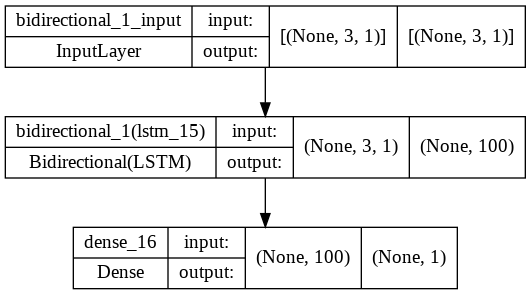

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 4559.6323
Epoch 2/500
1/1 [==============================] - 0s 20ms/step - loss: 4445.1665
Epoch 3/500
1/1 [==============================] - 0s 21ms/step - loss: 4330.5229
Epoch 4/500
1/1 [==============================] - 0s 17ms/step - loss: 4215.4819
Epoch 5/500
1/1 [==============================] - 0s 20ms/step - loss: 4099.8862
Epoch 6/500
1/1 [==============================] - 0s 30ms/step - loss: 3983.5059
Epoch 7/500
1/1 [==============================] - 0s 26ms/step - loss: 3866.0457
Epoch 8/500
1/1 [==============================] - 0s 17ms/step - loss: 3747.1946
Epoch 9/500
1/1 [==============================] - 0s 22ms/step - loss: 3626.9570
Epoch 10/500
1/1 [==============================] - 0s 19ms/step - loss: 3505.3730
Epoch 11/500
1/1 [==============================] - 0s 18ms/step - loss: 3381.9792
Epoch 12/500
1/1 [==============================] - 0s 23ms/step - loss: 3256.4109
Epoch 13/500
1/

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.60005]]


### Multivariate LSTM

En un problema multivariado tenemos múltiples series de tiempo paralelas de entrada, o sea varias series que son medidas en el mismo intervalo de tiempo.

Suponga el siguiente ejemplo:

In [ ]:
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convertir a [rows, columns]
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# apilar columnas
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [ ]:
print(out_seq)

[[ 25]
 [ 45]
 [ 65]
 [ 85]
 [105]
 [125]
 [145]
 [165]
 [185]]


In [ ]:
in_seq1

array([[10],
       [20],
       [30],
       [40],
       [50],
       [60],
       [70],
       [80],
       [90]])

In [ ]:
out_seq

array([[ 25],
       [ 45],
       [ 65],
       [ 85],
       [105],
       [125],
       [145],
       [165],
       [185]])

In [ ]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

In [ ]:
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences):
      break
    seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

Vamos a tomar 3 tiempos de cada combinación de las series

In [ ]:
n_steps = 3
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)
for i in range(len(X)):
  print(X[i], y[i])

(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


In [ ]:
n_features = X.shape[2]

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=500)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 18831.6602
Epoch 2/500
1/1 [==============================] - 0s 26ms/step - loss: 18566.1836
Epoch 3/500
1/1 [==============================] - 0s 22ms/step - loss: 18312.0918
Epoch 4/500
1/1 [==============================] - 0s 17ms/step - loss: 18066.7930
Epoch 5/500
1/1 [==============================] - 0s 37ms/step - loss: 17823.2832
Epoch 6/500
1/1 [==============================] - 0s 20ms/step - loss: 17574.6270
Epoch 7/500
1/1 [==============================] - 0s 43ms/step - loss: 17313.7734
Epoch 8/500
1/1 [==============================] - 0s 23ms/step - loss: 17033.9941
Epoch 9/500
1/1 [==============================] - 0s 20ms/step - loss: 16728.7480
Epoch 10/500
1/1 [==============================] - 0s 26ms/step - loss: 16398.0352
Epoch 11/500
1/1 [==============================] - 0s 34ms/step - loss: 16052.3037
Epoch 12/500
1/1 [==============================] - 0s 22ms/step - loss: 15713.0205
Epo

In [ ]:
x_input = np.array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[205.23364]]


### Multiples series paralelas con múltiples salidas

In [ ]:
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
in_seq3 = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
in_seq3

array([ 25,  45,  65,  85, 105, 125, 145, 165, 185])

In [ ]:
def split_sequences(sequences, n_steps):
  X, y = list(), list()
  for i in range(len(sequences)):
    end_ix = i + n_steps
    if end_ix > len(sequences)-1:
      break
    seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, in_seq3))

n_steps = 3
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

for i in range(len(X)):
  print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


Basado en este ejemplo donde estamos tomando 3 tiempo de la combinación de las tres series de entrada y debemos predecir tres salidas, una asociada a cada serie de entrada, que en este ejemplo estamos tratando de predecir el siguiente paso de tiempo para cada una, haremos el siguiente Stacked LSTM:

In [ ]:
n_features = X.shape[2]
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps,n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(X, y, epochs=400)

Epoch 1/400
1/1 [==============================] - 2s 2s/step - loss: 9792.9814
Epoch 2/400
1/1 [==============================] - 0s 21ms/step - loss: 9508.6475
Epoch 3/400
1/1 [==============================] - 0s 22ms/step - loss: 9262.5791
Epoch 4/400
1/1 [==============================] - 0s 21ms/step - loss: 9020.0635
Epoch 5/400
1/1 [==============================] - 0s 23ms/step - loss: 8763.4727
Epoch 6/400
1/1 [==============================] - 0s 29ms/step - loss: 8496.6025
Epoch 7/400
1/1 [==============================] - 0s 23ms/step - loss: 8214.4814
Epoch 8/400
1/1 [==============================] - 0s 23ms/step - loss: 7861.9868
Epoch 9/400
1/1 [==============================] - 0s 25ms/step - loss: 7415.0288
Epoch 10/400
1/1 [==============================] - 0s 32ms/step - loss: 6941.0884
Epoch 11/400
1/1 [==============================] - 0s 25ms/step - loss: 6485.5054
Epoch 12/400
1/1 [==============================] - 0s 24ms/step - loss: 6040.3579
Epoch 13/400
1/

In [ ]:
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input)
print(yhat)

[[100.38068 105.69623 206.41023]]


### Modelo Autoencoder (Predicción de series de tiempo de múltiples pasos)

Este modelo está definido para cuando tenemos como entrada y como salida secuencias o señales, tales como traducción de texto de un lenguaje a otro, o para predicción de series de tiempo de múltiples pasos.

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out
    if out_end_ix > len(sequence):
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [ ]:
# ejemplo de entrada
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# seleccionar el número de pasos de tiempo
n_steps_in, n_steps_out = 3, 2
# dividir la serie
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

In [ ]:
for i in range(len(X)):
  print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


In [ ]:
# reshape de [samples, timesteps] a [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))

In [ ]:
from tensorflow.keras.layers import TimeDistributed, RepeatVector

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

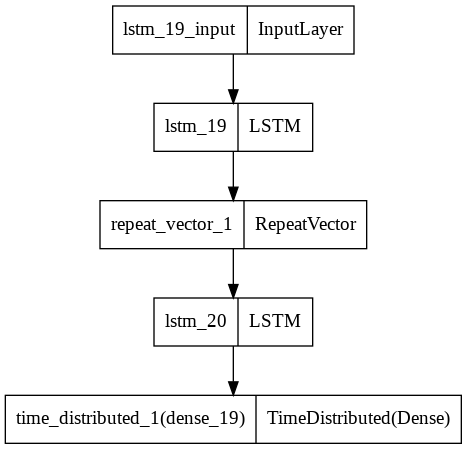

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model.fit(X, y, epochs=100)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 4403.8574
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 4305.4219
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 4204.0679
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 4093.9695
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 3970.2695
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 3830.2273
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 3670.1211
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 3484.5500
Epoch 9/100
1/1 [==============================] - 0s 18ms/step - loss: 3268.2522
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 3016.8101
Epoch 11/100
1/1 [==============================] - 0s 17ms/step - loss: 2727.4441
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 2399.6094
Epoch 13/100
1/

In [ ]:
x_input = np.array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[105.28161]
  [118.72791]]]


### Ejemplo1: Predecir venta de carro del próximo mes, a partir del histórico de varios meses.

Usaremos un ejemplo de ventas de carro en siguiente [csv](https://github.com/jbrownlee/Datasets/blob/d20fcb6402ae34e653d4513b00f39257bb37ed7f/monthly-car-sales.csv)

Las ventas están mensuales y se quiere predecir las ventas para el próximo mes.


Los datos se deben organizar como:

| X | Y |
| --- | --- |
|mes1, mes2, mes3, | mes4|
|mes2, mes3, mes4, | mes5|
|mes3, mes4, mes5, | mes6|
|...| ...|

In [3]:
!wget 'https://github.com/jbrownlee/Datasets/blob/master/monthly-car-sales.csv'

--2024-04-26 21:19:22--  https://github.com/jbrownlee/Datasets/blob/master/monthly-car-sales.csv
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘monthly-car-sales.csv’

monthly-car-sales.c     [ <=>                ] 281.07K  --.-KB/s    in 0.05s   

2024-04-26 21:19:22 (5.68 MB/s) - ‘monthly-car-sales.csv’ saved [287816]



In [10]:
from math import sqrt
from numpy import array,mean,std
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#### Solución usando un MLP

In [5]:
url='https://github.com/jbrownlee/Datasets/blob/d20fcb6402ae34e653d4513b00f39257bb37ed7f/monthly-car-sales.csv?raw=true'
serie = pd.read_csv(url, header=0,index_col=0)

In [56]:
serie

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587
...,...
1968-08,16722
1968-09,14385
1968-10,21342


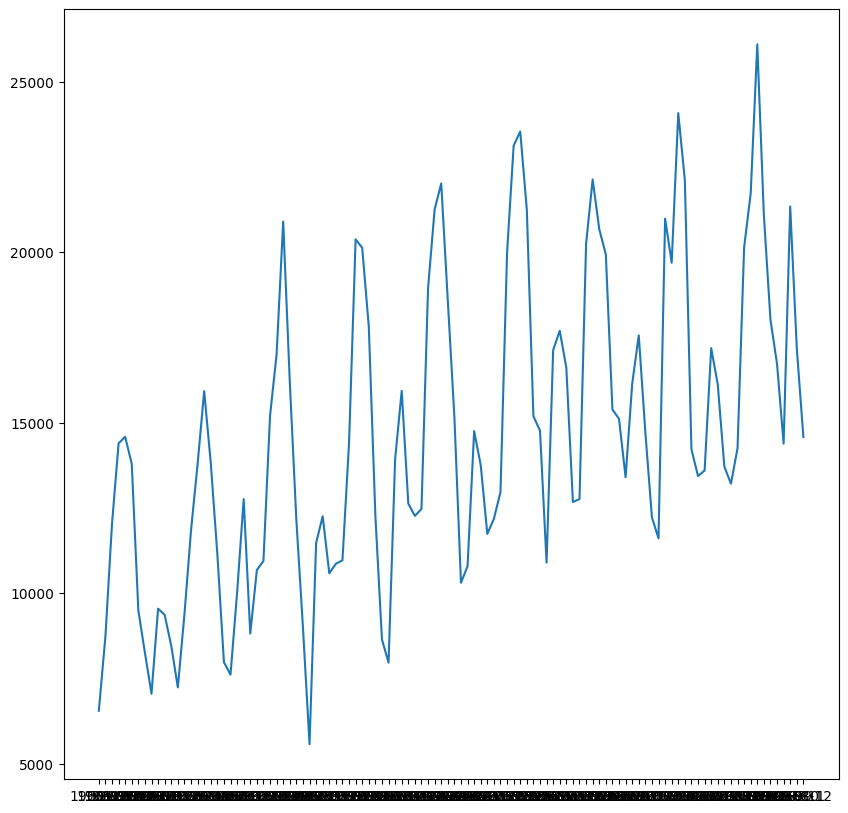

In [7]:
plt.figure(figsize=(10,10))
plt.plot(serie)
plt.show()

In [57]:
data = serie.values

In [58]:
data

array([[ 6550],
       [ 8728],
       [12026],
       [14395],
       [14587],
       [13791],
       [ 9498],
       [ 8251],
       [ 7049],
       [ 9545],
       [ 9364],
       [ 8456],
       [ 7237],
       [ 9374],
       [11837],
       [13784],
       [15926],
       [13821],
       [11143],
       [ 7975],
       [ 7610],
       [10015],
       [12759],
       [ 8816],
       [10677],
       [10947],
       [15200],
       [17010],
       [20900],
       [16205],
       [12143],
       [ 8997],
       [ 5568],
       [11474],
       [12256],
       [10583],
       [10862],
       [10965],
       [14405],
       [20379],
       [20128],
       [17816],
       [12268],
       [ 8642],
       [ 7962],
       [13932],
       [15936],
       [12628],
       [12267],
       [12470],
       [18944],
       [21259],
       [22015],
       [18581],
       [15175],
       [10306],
       [10792],
       [14752],
       [13754],
       [11738],
       [12181],
       [12965],
       [

##### Normalizar los datos

In [59]:
sc = MinMaxScaler(feature_range = (0, 1))
data_scaled = sc.fit_transform(data)
data_scaled

array([[0.04783011],
       [0.15391359],
       [0.31454873],
       [0.42993522],
       [0.43928693],
       [0.40051629],
       [0.19141786],
       [0.13068043],
       [0.07213482],
       [0.19370708],
       [0.18489114],
       [0.14066534],
       [0.08129171],
       [0.18537821],
       [0.30534314],
       [0.40017534],
       [0.50450538],
       [0.4019775 ],
       [0.2715406 ],
       [0.11723735],
       [0.09945935],
       [0.21659929],
       [0.35025084],
       [0.1581998 ],
       [0.24884321],
       [0.26199406],
       [0.46914422],
       [0.55730359],
       [0.74677317],
       [0.51809459],
       [0.32024743],
       [0.16701573],
       [0.        ],
       [0.28766256],
       [0.3257513 ],
       [0.24426477],
       [0.25785398],
       [0.26287078],
       [0.43042229],
       [0.72139691],
       [0.7091715 ],
       [0.5965613 ],
       [0.32633578],
       [0.14972481],
       [0.11660416],
       [0.40738396],
       [0.50499245],
       [0.343

Dividiendo en entrenamiento y prueba (dejando los 12 últimos meses de prueba)

In [60]:
n_test = 12
#train, test=data[:-n_test], data[-n_test:]
train, test=data_scaled[:-n_test], data_scaled[-n_test:]

Preparar los datos para un problema supervisado

In [61]:
def series_to_supervised(data, n_in, n_out=1):
  df = pd.DataFrame(data)
  cols = list()
  # serie de entrada: (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # serie de predicción: (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # concatenar datos
  agg = pd.concat(cols, axis=1)
  # quitar valores vacíos
  agg.dropna(inplace=True)
  return agg.values

In [62]:
n_input=24
data_transform=series_to_supervised(data_scaled, n_input)
train_data,test_data= data_transform[:-n_test], data_transform[-n_test:]

In [63]:
train_data

array([[0.04783011, 0.15391359, 0.31454873, ..., 0.35025084, 0.1581998 ,
        0.24884321],
       [0.15391359, 0.31454873, 0.42993522, ..., 0.1581998 , 0.24884321,
        0.26199406],
       [0.31454873, 0.42993522, 0.43928693, ..., 0.24884321, 0.26199406,
        0.46914422],
       ...,
       [0.56314841, 0.59076518, 0.53786956, ..., 0.38312795, 0.39111587,
        0.5659247 ],
       [0.59076518, 0.53786956, 0.34611076, ..., 0.39111587, 0.5659247 ,
        0.5139058 ],
       [0.53786956, 0.34611076, 0.35029955, ..., 0.5659247 , 0.5139058 ,
        0.39671716]])

In [64]:
train_x, train_y = train_data[:, :-1], train_data[:, -1]

In [65]:
test_x, test_y = test_data[:, :-1], test_data[:, -1]

In [66]:
len(train_data[0])

25

In [67]:
model = Sequential()
model.add(Dense(500, activation='relu', input_dim=n_input))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [68]:
model.fit(train_x, train_y, epochs=100, batch_size=100)

Epoch 1/100
1/1 [==============================] - 1s 630ms/step - loss: 0.4688
Epoch 2/100
1/1 [==============================] - 0s 9ms/step - loss: 0.2718
Epoch 3/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1391
Epoch 4/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0682
Epoch 5/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0513
Epoch 6/100
1/1 [==============================] - 0s 10ms/step - loss: 0.0701
Epoch 7/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0988
Epoch 8/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1168
Epoch 9/100
1/1 [==============================] - 0s 9ms/step - loss: 0.1174
Epoch 10/100
1/1 [==============================] - 0s 8ms/step - loss: 0.1041
Epoch 11/100
1/1 [==============================] - 0s 9ms/step - loss: 0.0833
Epoch 12/100
1/1 [==============================] - 0s 8ms/step - loss: 0.0618
Epoch 13/100
1/1 [==============================] - 0s 9ms

Creando los datos para prueba, tomando desde los últimos datos del train para poder predecir el primero de test y corriendo un paso cada vez

In [69]:
input_test = [x for x in train]
array(input_test[-n_input:]).reshape(1, n_input)

array([[0.34611076, 0.35029955, 0.71506502, 0.80692611, 0.73591155,
        0.69967366, 0.47830111, 0.46490673, 0.38152063, 0.51468511,
        0.58418976, 0.44576494, 0.32424139, 0.29418927, 0.75091325,
        0.68793532, 0.90170961, 0.80590327, 0.42141152, 0.38312795,
        0.39111587, 0.5659247 , 0.5139058 , 0.39671716]])

In [70]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  x_input = array(input_test[-n_input:]).reshape(1, n_input)
  yhat = model.predict(x_input, verbose=0)
  predictions.append(yhat[0])
  input_test.append(test[i])

In [71]:
for t, p in zip(test, predictions):
  print(t, p, t-p)

[0.37221762] [0.35220757] [0.02001005]
[0.42292144] [0.3952719] [0.02764954]
[0.70970727] [0.66909766] [0.04060961]
[0.78695631] [0.83777654] [-0.05082023]
[1.] [0.87082624] [0.12917376]
[0.75573523] [0.7855936] [-0.0298584]
[0.60669232] [0.5302125] [0.0764798]
[0.54327602] [0.42874524] [0.11453078]
[0.42944815] [0.45373353] [-0.02428538]
[0.76830159] [0.56413907] [0.20416252]
[0.56558375] [0.61627865] [-0.0506949]
[0.43879986] [0.46400362] [-0.02520376]


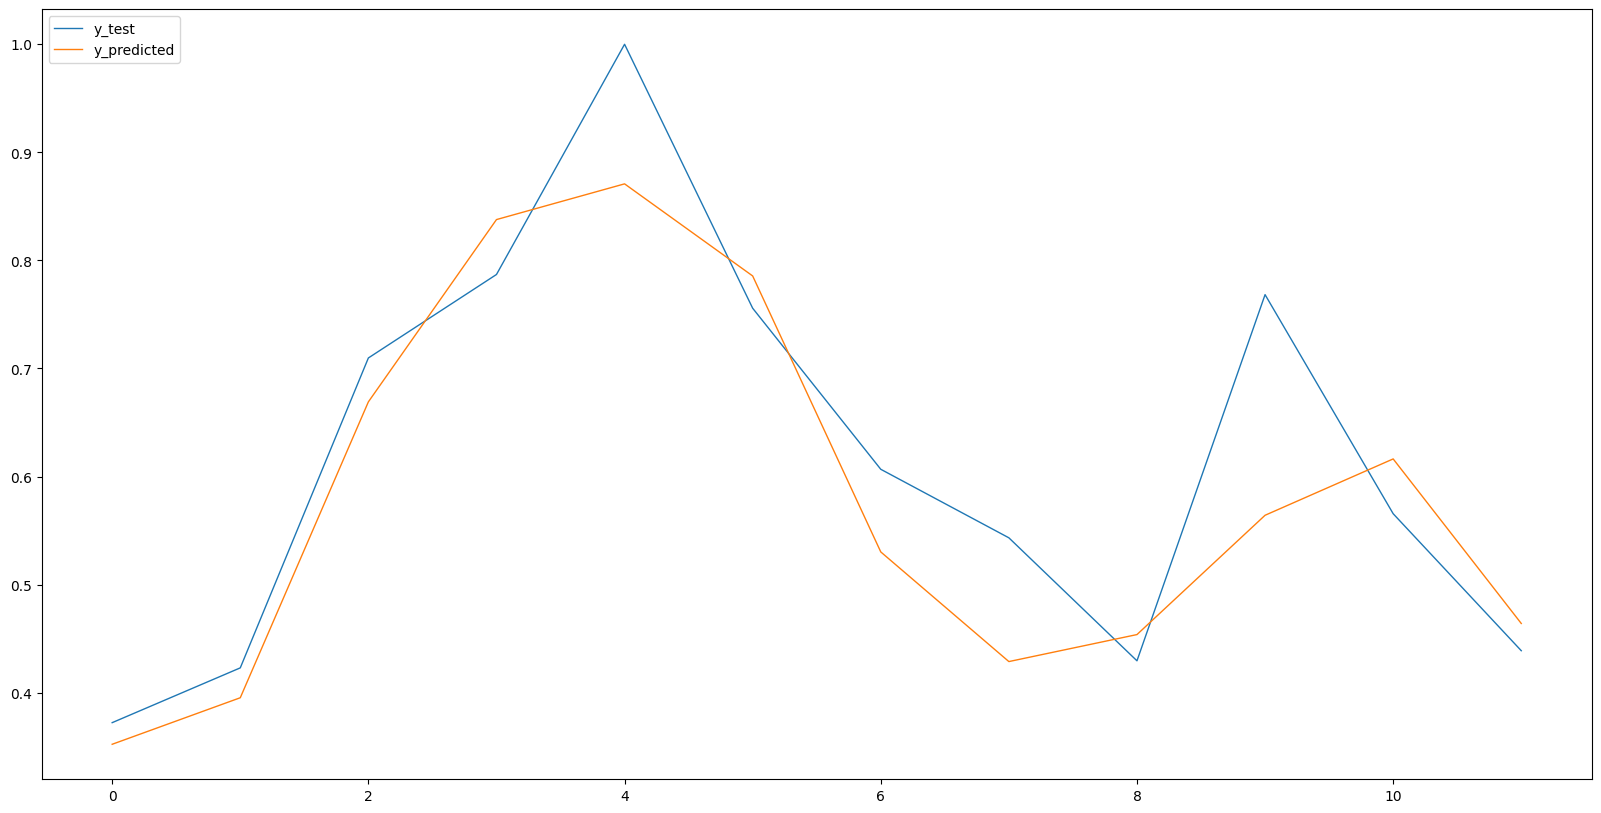

In [72]:
plt.figure(figsize=(20, 10))
plt.plot(test, label='y_test',linewidth=1)
plt.plot(predictions, label='y_predicted',linewidth=1)
plt.legend(loc='upper left')
plt.show()

In [25]:
import plotly.express as px

In [73]:
test_result=serie.iloc[-n_test:,:]
test_result

,Sales
Month,
1968-01,13210
1968-02,14251
1968-03,20139
1968-04,21725
1968-05,26099
1968-06,21084
1968-07,18024
1968-08,16722
1968-09,14385


Convertir predictions a la escala original con **inverse_transform**

In [74]:
predicted_transform = sc.inverse_transform(predictions)
predicted_transform

array([[12799.1736457 ],
       [13683.32732379],
       [19305.24409795],
       [22768.39017785],
       [23446.93362284],
       [21697.0227946 ],
       [16453.79328001],
       [14370.56852189],
       [14883.60317877],
       [17150.33920771],
       [18220.81692982],
       [15094.4583742 ]])

In [75]:
test_result['Predict_MLP']=predicted_transform.flatten()

<ipython-input-75-e3b61e68e612>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
test_result

,Sales,Predict_MLP
Month,,
1968-01,13210,12799.173646
1968-02,14251,13683.327324
1968-03,20139,19305.244098
1968-04,21725,22768.390178
1968-05,26099,23446.933623
1968-06,21084,21697.022795
1968-07,18024,16453.793280
1968-08,16722,14370.568522
1968-09,14385,14883.603179


In [78]:
fig = px.line(test_result, x=test_result.index, y=["Sales", "Predict_MLP"], template = 'plotly_dark')
fig.show()

In [31]:
# estimar el error de predicción
error = sqrt(mean_squared_error(test_y, predictions))
print('%.3f RMSE' % error)

0.076 RMSE


#### Solución usando LSTM

LSTM funciona mejor si los datos son estacionarios. Esto significa que se realizan operaciones de diferenciación para eliminar la estructura de tendencia y estacional. En el caso del conjunto de datos de ventas de automóviles, podemos hacer la estacionaliad de los datos realizando un ajuste estacional, es decir, restando el valor de hace un año de cada observación.
Esto significa que el primera año se descarta ya que no tenemos un año anterior.

In [79]:
# Para la diferencia por año, n_diff=12
def difference(data, n_diff):
  return [data[i] - data[i - n_diff] for i in range(n_diff, len(data))]

In [80]:
n_input, n_nodes, n_epochs, n_batch, n_diff = [12, 50, 100, 100, 12]

In [81]:
data = serie.values
sc = MinMaxScaler(feature_range = (0, 1))
data = sc.fit_transform(data)

In [82]:
data = series_to_supervised(data, n_input)
train_x, train_y = data[:, :-1], data[:, -1]
train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))

In [83]:
train_x.shape

(96, 12, 1)

In [84]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True, input_shape=(n_input, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [85]:
model.fit(train_x, train_y, epochs=200, batch_size=n_batch)

Epoch 1/200
1/1 [==============================] - 3s 3s/step - loss: 0.2558
Epoch 2/200
1/1 [==============================] - 0s 38ms/step - loss: 0.2274
Epoch 3/200
1/1 [==============================] - 0s 37ms/step - loss: 0.2029
Epoch 4/200
1/1 [==============================] - 0s 37ms/step - loss: 0.1787
Epoch 5/200
1/1 [==============================] - 0s 37ms/step - loss: 0.1510
Epoch 6/200
1/1 [==============================] - 0s 36ms/step - loss: 0.1192
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0878
Epoch 8/200
1/1 [==============================] - 0s 40ms/step - loss: 0.0599
Epoch 9/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0388
Epoch 10/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0501
Epoch 11/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0781
Epoch 12/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0710
Epoch 13/200
1/1 [==============================] -

In [86]:
n_diff=0

In [87]:
def model_predict(model, history, n_input):
  # preparar datos
  correction = 0.0
  if n_diff > 0:
    correction = history[-n_diff]
    history = difference(history, n_diff)
  x_input = array(history[-n_input:]).reshape((1, n_input, 1))
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return correction + yhat[0]

In [88]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  x_input = array(input_test[-n_input:]).reshape((1, n_input, 1))
  yhat = model.predict(x_input, verbose=0)
  predictions.append(yhat[0])
  input_test.append(test[i])
error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

0.075 RMSE


In [89]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  yhat =  model_predict(model, input_test, n_input)
  predictions.append(yhat)
  input_test.append(test[i])

error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

0.075 RMSE


In [90]:
predictions

[array([0.37859645], dtype=float32),
 array([0.45504722], dtype=float32),
 array([0.6992531], dtype=float32),
 array([0.77936983], dtype=float32),
 array([0.9099869], dtype=float32),
 array([0.81611663], dtype=float32),
 array([0.48978195], dtype=float32),
 array([0.45315665], dtype=float32),
 array([0.4758608], dtype=float32),
 array([0.59529585], dtype=float32),
 array([0.5370384], dtype=float32),
 array([0.41625798], dtype=float32)]

In [91]:
sc.inverse_transform(predictions)

array([[13340.96381471],
       [14910.57447365],
       [19924.3650322 ],
       [21569.24200201],
       [24250.941315  ],
       [22323.6905517 ],
       [15623.71313217],
       [14871.75918251],
       [15337.89817348],
       [17790.01902372],
       [16593.93510026],
       [14114.19253576]])

In [92]:
test_result['Predict_LSTM']=sc.inverse_transform(predictions).flatten()

<ipython-input-92-0f2b8534465c>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [94]:
fig = px.line(test_result, x=test_result.index, y=["Sales", "Predict_MLP", "Predict_LSTM"], template = 'plotly_dark')
fig.show()

In [110]:
model = Sequential()
model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [111]:
model.fit(train_x, train_y, epochs=200, batch_size=n_batch)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.2596
Epoch 2/200
1/1 [==============================] - 0s 17ms/step - loss: 0.1787
Epoch 3/200
1/1 [==============================] - 0s 13ms/step - loss: 0.1144
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0631
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0434
Epoch 6/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0630
Epoch 7/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0820
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 0.0818
Epoch 9/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0499
Epoch 10/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0433
Epoch 11/200
1/1 [==============================] - 0s 13ms/step - loss: 0.0478
Epoch 12/200
1/1 [==============================] - 0s 15ms/step - loss: 0.0446
Epoch 13/200
1/1 [==============================] -

In [112]:
input_test = [x for x in train]
predictions=[]
for i in range(len(test)):
  yhat =  model_predict(model, input_test, n_input)
  predictions.append(yhat)
  input_test.append(test[i])

error = sqrt(mean_squared_error(test, predictions))
print('%.3f RMSE' % error)

0.108 RMSE


In [113]:
test_result['Predict_LSTM2']=sc.inverse_transform(predictions).flatten()

<ipython-input-113-77ff6c537af1>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [114]:
fig = px.line(test_result, x=test_result.index, y=["Sales", "Predict_MLP", "Predict_LSTM","Predict_LSTM2"], template = 'plotly_dark')
fig.show()

### Ejemplo: Datos meteorológicos (Ejemplo tomado de [keras](https://www.tensorflow.org/tutorials/structured_data/time_series))

Este conjunto de datos tiene 14 características diferentes, como la temperatura del aire, la presión atmosférica y la humedad. Estos se recopilaron cada 10 minutos, a partir de 2003. Para mayor eficiencia, utilizará solo los datos recopilados entre 2009 y 2016.

Vamos a hacer predicciones por hora


#### Cargar datos

In [115]:
import os

In [116]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 0s 0us/step


In [167]:
df = pd.read_csv(csv_path)

In [168]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


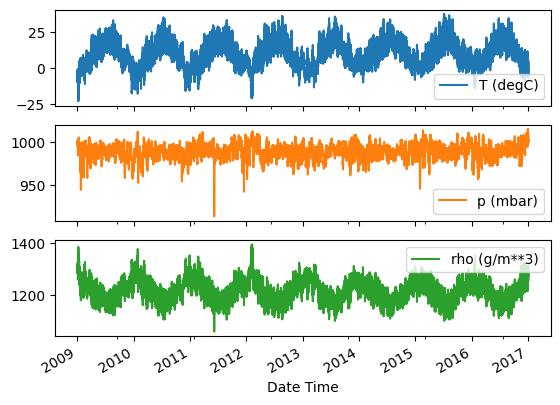

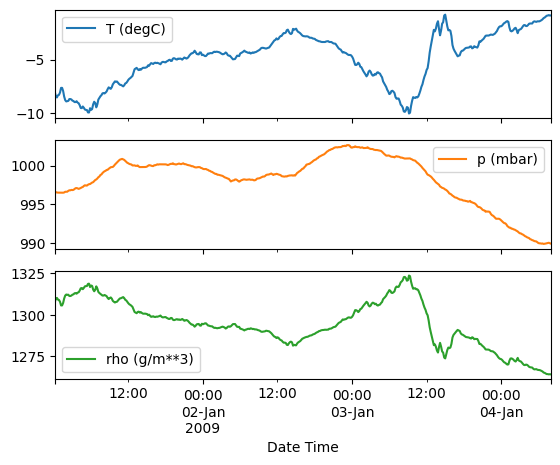

In [169]:
date_time = pd.to_datetime(df['Date Time'], format='%d.%m.%Y %H:%M:%S')
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [120]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


#### Preprocesar los datos

In [170]:
split_fraction = 0.70
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72
learning_rate = 0.001
batch_size = 256
epochs = 10

In [171]:
def normalize(data, train_split):
  data_mean = data[:train_split].mean(axis=0)
  data_std = data[:train_split].std(axis=0)
  return (data - data_mean) / data_std

In [172]:
feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

#### Datos de entrenamiento

Vamos a seleccionar algunos parámetros

In [173]:
print(
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)

Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


In [174]:
date_time_key = "Date Time"
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6
0,0.947799,-1.979102,-1.303077,-0.784476,-1.487254,2.215824,-0.734960
1,0.953826,-2.024166,-1.316076,-0.786553,-1.505970,2.265877,-0.937559
2,0.949005,-2.035722,-1.318676,-0.788629,-1.509713,2.276620,-1.283939
3,0.946594,-2.012611,-1.312176,-0.790706,-1.494740,2.250983,-1.185907
4,0.946594,-2.007989,-1.310877,-0.790706,-1.494740,2.246344,-1.198978


In [175]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

La etiqueta de los datos comienza desde la observación 792

In [176]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(7)]].values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)

In [177]:
x_train

array([[ 0.94779926, -1.97910178, -1.30307696, ..., -1.48725412,
         2.21582439, -0.73495957],
       [ 0.95382569, -2.02416646, -1.31607626, ..., -1.5059698 ,
         2.26587719, -0.93755919],
       [ 0.94900455, -2.03572151, -1.31867612, ..., -1.50971294,
         2.27662023, -1.28393919],
       ...,
       [ 0.22462871,  0.60922869,  0.39723145, ...,  1.50351159,
        -0.59006212,  0.27150305],
       [ 0.21378116,  0.61847273,  0.40763089, ...,  1.52597041,
        -0.6017818 , -0.4539343 ],
       [ 0.20413888,  0.60229566,  0.38813194, ...,  1.48105278,
        -0.58786468, -0.96370108]])

La siguiente función *timeseries_dataset_from_array* toma una secuencia de puntos de datos recopilados a intervalos iguales, junto con parámetros de series de tiempo como la longitud de las secuencias / ventanas, el espaciado entre dos secuencias / ventanas, etc., para producir lotes de entradas de subserie temporal y objetivos muestreados de las principales series temporales.

In [178]:
dataset_train = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

#### Conjunto de validación

In [179]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
y_val = features.iloc[label_start:][[1]]

dataset_val = tf.keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Entrada:", inputs.numpy().shape)
print("Salida:", targets.numpy().shape)

Entrada: (256, 120, 7)
Salida: (256, 1)


In [180]:
len(y_val)

125374

#### Entrenamiento

In [181]:
inputs = tf.keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = tf.keras.layers.LSTM(32)(inputs)
outputs = tf.keras.layers.Dense(1)(lstm_out)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm_17 (LSTM)              (None, 32)                5120      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5153 (20.13 KB)
Trainable params: 5153 (20.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [182]:
path_checkpoint = "model_checkpoint.h5"
es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=5,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/5
1147/1148 [============================>.] - ETA: 0s - loss: 0.2134
Epoch 1: val_loss improved from inf to 0.14419, saving model to model_checkpoint.h5
1148/1148 [==============================] - 61s 51ms/step - loss: 0.2134 - val_loss: 0.1442
Epoch 2/5
1146/1148 [============================>.] - ETA: 0s - loss: 0.1280
Epoch 2: val_loss improved from 0.14419 to 0.12754, saving model to model_checkpoint.h5
1148/1148 [==============================] - 58s 51ms/step - loss: 0.1280 - val_loss: 0.1275
Epoch 3/5
1146/1148 [============================>.] - ETA: 0s - loss: 0.1160
Epoch 3: val_loss improved from 0.12754 to 0.12750, saving model to model_checkpoint.h5
1148/1148 [==============================] - 58s 51ms/step - loss: 0.1160 - val_loss: 0.1275
Epoch 4/5
1147/1148 [============================>.] - ETA: 0s - loss: 0.1115
Epoch 4: val_loss did not improve from 0.12750
1148/1148 [==============================] - 58s 50ms/step - loss: 0.1115 - val_loss: 0.1333
Epoch 5/5

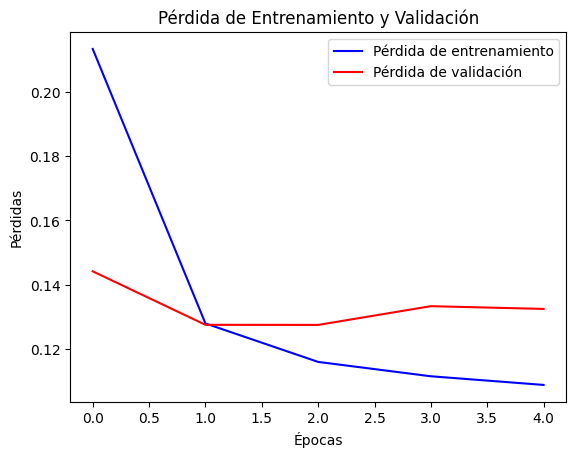

In [183]:
def visualize_loss(history, title):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, "b", label="Pérdida de entrenamiento")
  plt.plot(epochs, val_loss, "r", label="Pérdida de validación")
  plt.title(title)
  plt.xlabel("Épocas")
  plt.ylabel('Pérdidas')
  plt.legend()
  plt.show()


visualize_loss(history, "Pérdida de Entrenamiento y Validación")

#### Predicción

8/8 [==============================] - 0s 5ms/step


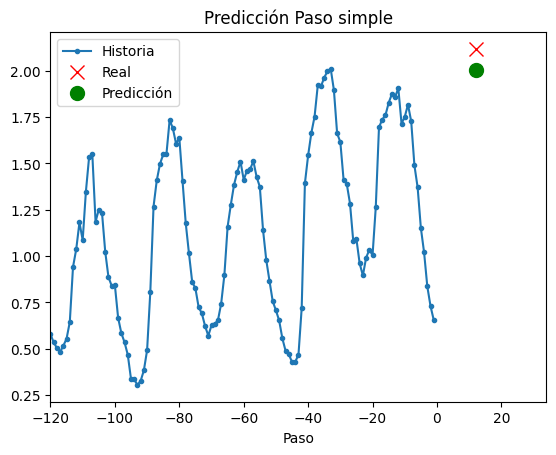

8/8 [==============================] - 0s 4ms/step


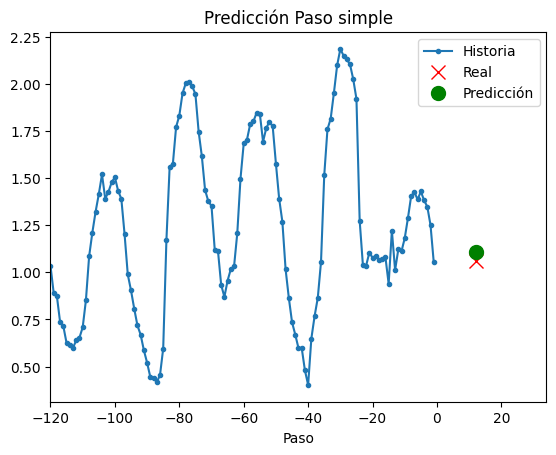

8/8 [==============================] - 0s 5ms/step


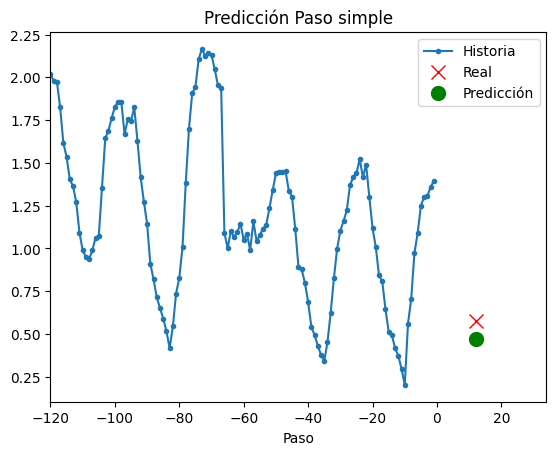

8/8 [==============================] - 0s 5ms/step


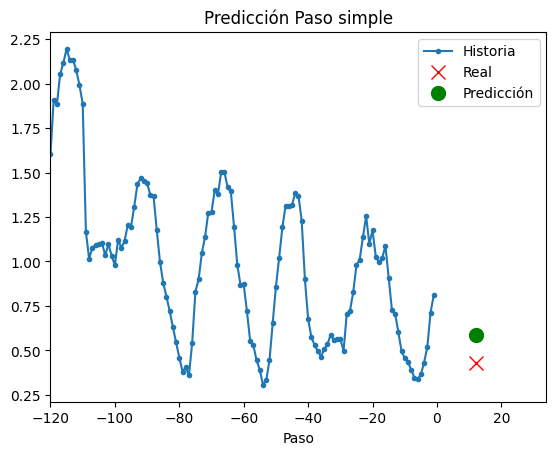

8/8 [==============================] - 0s 5ms/step


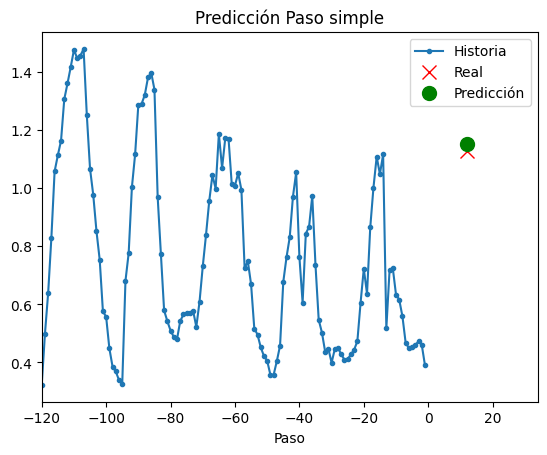

In [184]:
def show_plot(plot_data, delta, title):
    labels = ["Historia", "Real", "Predicción"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Paso")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Predicción Paso simple",
    )

In [185]:
X_val=[]
y_val=[]
y_predict=[]
for x,y in dataset_val:
  X_val.append(x[0][:, 1].numpy())
  y_val.append(y[0].numpy())
  y_predict.append(model.predict(x)[0])

8/8 [==============================] - 0s 5ms/step


In [186]:
len(y_predict)

487

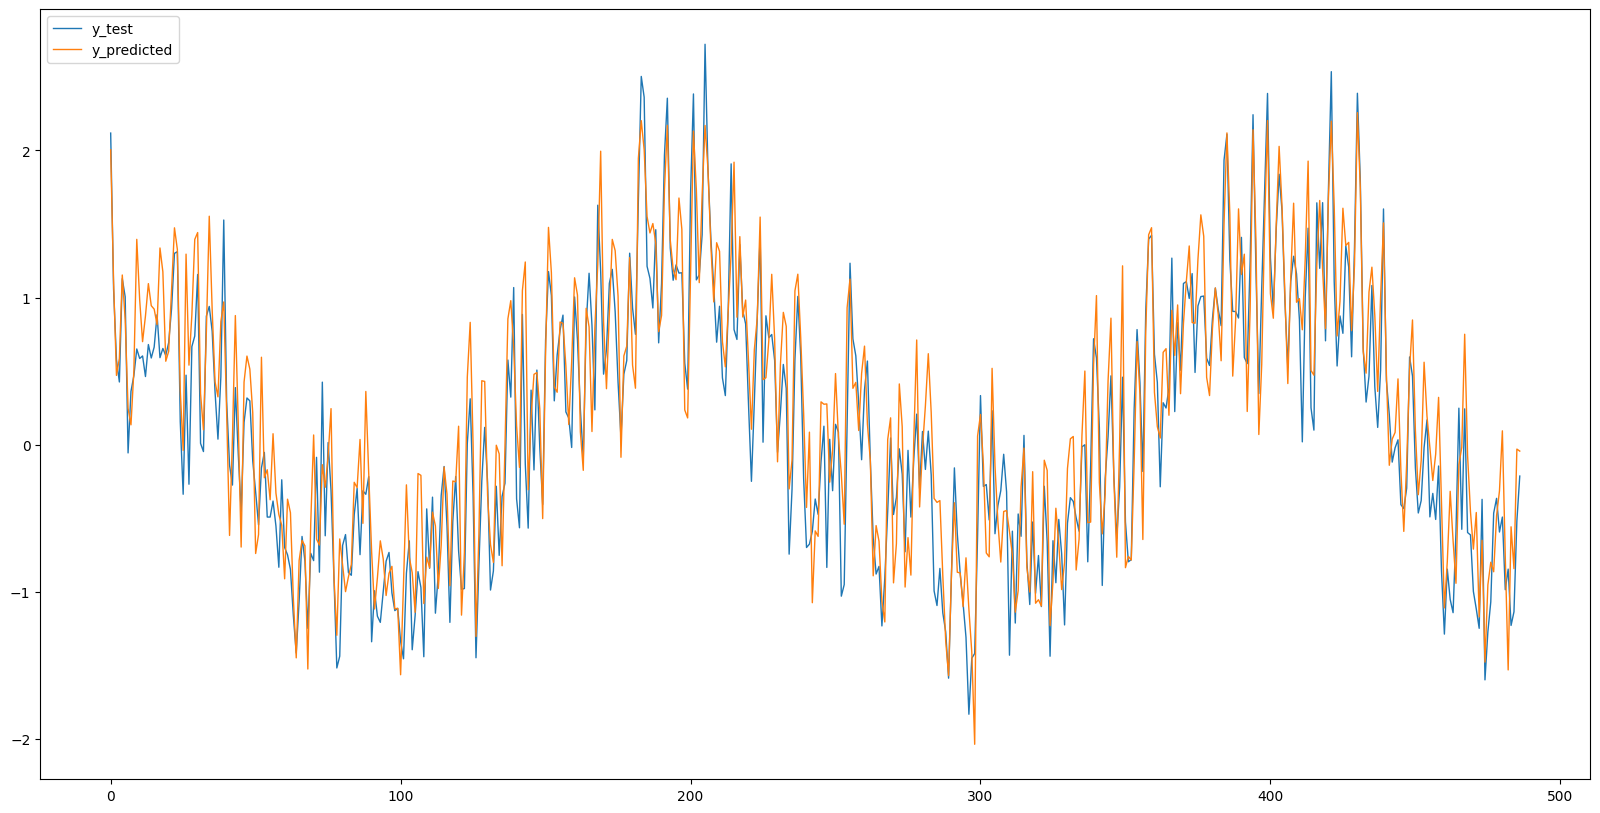

In [187]:
plt.figure(figsize=(20, 10))
plt.plot(y_val, label='y_test',linewidth=1)
plt.plot(y_predict, label='y_predicted',linewidth=1)
plt.legend(loc='upper left')
plt.show()

### Ejemplo: Clasificación de series de tiempo, reconocimiento usando Smartphones

Es el problema de predecir lo que está haciendo una persona basándose en un rastro de su movimiento mediante sensores.

Un conjunto de datos estándar de reconocimiento de actividad humana es el "Conjunto de datos de reconocimiento de actividad mediante teléfonos inteligentes", disponible en 2012.

Son datos de 30 sujetos de entre 19 y 48 años que realizaban una de las seis actividades estándar mientras usaban un teléfono inteligente montado en la cintura que registraba los datos de movimiento. Se grabó un video de cada sujeto realizando las actividades y los datos de movimiento se etiquetaron manualmente a partir de estos videos.

Las seis actividades realizadas fueron las siguientes:

- Caminando
- Subiendo escaleras
- Bajando escaleras
- Sentado
- De pie
- Acostado

Los datos de movimiento registrados fueron los datos del acelerómetro x, y, z (aceleración lineal) y los datos giroscópicos (velocidad angular) del teléfono inteligente, específicamente un Samsung Galaxy S II. Las observaciones se registraron a 50 Hz (es decir, 50 puntos de datos por segundo). Cada sujeto realizó la secuencia de actividades dos veces; una vez con el dispositivo en su lado izquierdo y una vez con el dispositivo en su lado derecho.

In [123]:
!wget 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/HAR_Smartphones.zip'

--2024-04-26 22:03:12--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/HAR_Smartphones.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/zip]
Saving to: ‘HAR_Smartphones.zip’

HAR_Smartphones.zip 100%[===================>]  58.17M   211MB/s    in 0.3s    

2024-04-26 22:03:14 (211 MB/s) - ‘HAR_Smartphones.zip’ saved [60999314/60999314]



In [124]:
!unzip '/content/HAR_Smartphones.zip'

Archive:  /content/HAR_Smartphones.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating

In [39]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

#### Cargar los datos

In [125]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + '/content/UCI HAR Dataset/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + '/content/UCI HAR Dataset/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	return trainX, trainy, testX, testy

In [126]:
trainX, trainy, testX, testy = load_dataset()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


#### Crear modelo

In [147]:
verbose, epochs, batch_size = 1, 15, 64
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, return_sequences=True,input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(200, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [148]:
# Entrenar
model.fit(trainX, trainy, epochs=20, batch_size=batch_size, validation_data=(testX, testy), verbose=1)

Epoch 1/20
115/115 [==============================] - 11s 37ms/step - loss: 1.0000 - accuracy: 0.5706 - val_loss: 0.7919 - val_accuracy: 0.6882
Epoch 2/20
115/115 [==============================] - 3s 29ms/step - loss: 0.5851 - accuracy: 0.7446 - val_loss: 0.6034 - val_accuracy: 0.7788
Epoch 3/20
115/115 [==============================] - 5s 42ms/step - loss: 0.3352 - accuracy: 0.8770 - val_loss: 0.4406 - val_accuracy: 0.8744
Epoch 4/20
115/115 [==============================] - 3s 28ms/step - loss: 0.3170 - accuracy: 0.8776 - val_loss: 0.4552 - val_accuracy: 0.8507
Epoch 5/20
115/115 [==============================] - 3s 27ms/step - loss: 0.2096 - accuracy: 0.9236 - val_loss: 0.4488 - val_accuracy: 0.8677
Epoch 6/20
115/115 [==============================] - 4s 32ms/step - loss: 0.1571 - accuracy: 0.9415 - val_loss: 0.3709 - val_accuracy: 0.8955
Epoch 7/20
115/115 [==============================] - 3s 26ms/step - loss: 0.1806 - accuracy: 0.9324 - val_loss: 0.7179 - val_accuracy: 0.758

#### Evaluar el modelo

In [149]:
# Evaluar
p, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

In [150]:
accuracy=accuracy*100
accuracy

84.42484140396118

In [151]:
predicted=model.predict(testX)

93/93 [==============================] - 3s 13ms/step


In [152]:
testyy=np.argmax(testy,axis=1)
predictedy=np.argmax(predicted,axis=1)

In [153]:
from sklearn.metrics import confusion_matrix

In [154]:
cm=confusion_matrix(testyy,predictedy)
cm

array([[445,   1,  50,   0,   0,   0],
       [ 60, 405,   6,   0,   0,   0],
       [  0,   9, 411,   0,   0,   0],
       [ 24,   3,   0, 392,  67,   5],
       [122,   1,   0,  84, 325,   0],
       [  0,  27,   0,   0,   0, 510]])

In [155]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

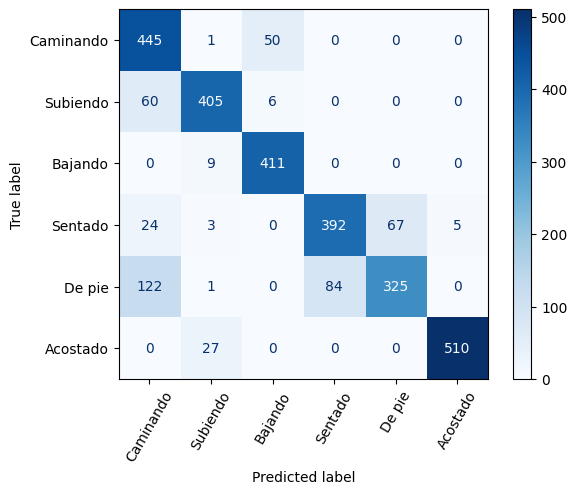

In [156]:
classNames = ['Caminando','Subiendo','Bajando','Sentado','De pie','Acostado']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=60)

#### Modelo2: Salida con representación categórica

In [157]:
trainyy=np.argmax(trainy,axis=1)
trainyy

array([4, 4, 4, ..., 1, 1, 1])

In [158]:
testyy=np.argmax(testy,axis=1)
testyy

array([4, 4, 4, ..., 1, 1, 1])

In [159]:
numclass=len(np.unique(testyy))
numclass

6

In [160]:
n_timesteps, n_features= trainX.shape[1], trainX.shape[2]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(numclass, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [161]:
model.fit(trainX, trainyy, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/15
115/115 [==============================] - 4s 12ms/step - loss: 1.1899 - accuracy: 0.5030
Epoch 2/15
115/115 [==============================] - 1s 12ms/step - loss: 0.7588 - accuracy: 0.6715
Epoch 3/15
115/115 [==============================] - 2s 14ms/step - loss: 0.5952 - accuracy: 0.7486
Epoch 4/15
115/115 [==============================] - 1s 12ms/step - loss: 0.5412 - accuracy: 0.7798
Epoch 5/15
115/115 [==============================] - 1s 11ms/step - loss: 0.3794 - accuracy: 0.8630
Epoch 6/15
115/115 [==============================] - 1s 11ms/step - loss: 0.2442 - accuracy: 0.9168
Epoch 7/15
115/115 [==============================] - 1s 11ms/step - loss: 0.2150 - accuracy: 0.9233
Epoch 8/15
115/115 [==============================] - 1s 11ms/step - loss: 0.2167 - accuracy: 0.9229
Epoch 9/15
115/115 [==============================] - 1s 10ms/step - loss: 0.1509 - accuracy: 0.9427
Epoch 10/15
115/115 [==============================] - 1s 10ms/step - loss: 0.1443 - accura

In [162]:
_,accuracy=model.evaluate(testX, testyy, batch_size=batch_size, verbose=0)
accuracy*100

90.15948176383972

In [163]:
predicted=model.predict(testX)

93/93 [==============================] - 1s 5ms/step


In [164]:
ypredicted=np.argmax(predicted,axis=1)
ypredicted

array([4, 4, 4, ..., 1, 1, 1])

In [165]:
cm=confusion_matrix(testyy,ypredicted)
cm

array([[465,  18,  13,   0,   0,   0],
       [ 21, 440,  10,   0,   0,   0],
       [  3,   0, 417,   0,   0,   0],
       [  0,   4,   6, 339, 142,   0],
       [  0,   2,   0,  44, 486,   0],
       [  0,  27,   0,   0,   0, 510]])

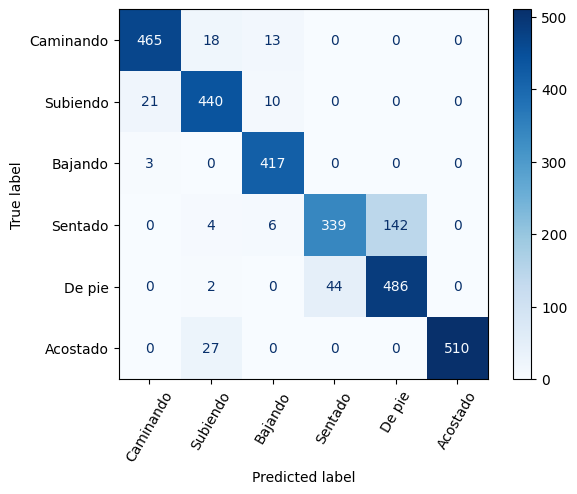

In [166]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classNames)
disp.plot(cmap=plt.cm.Blues,xticks_rotation=60)